<a href="https://colab.research.google.com/github/be1le/DL/blob/master/BM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Boltzmann Machine
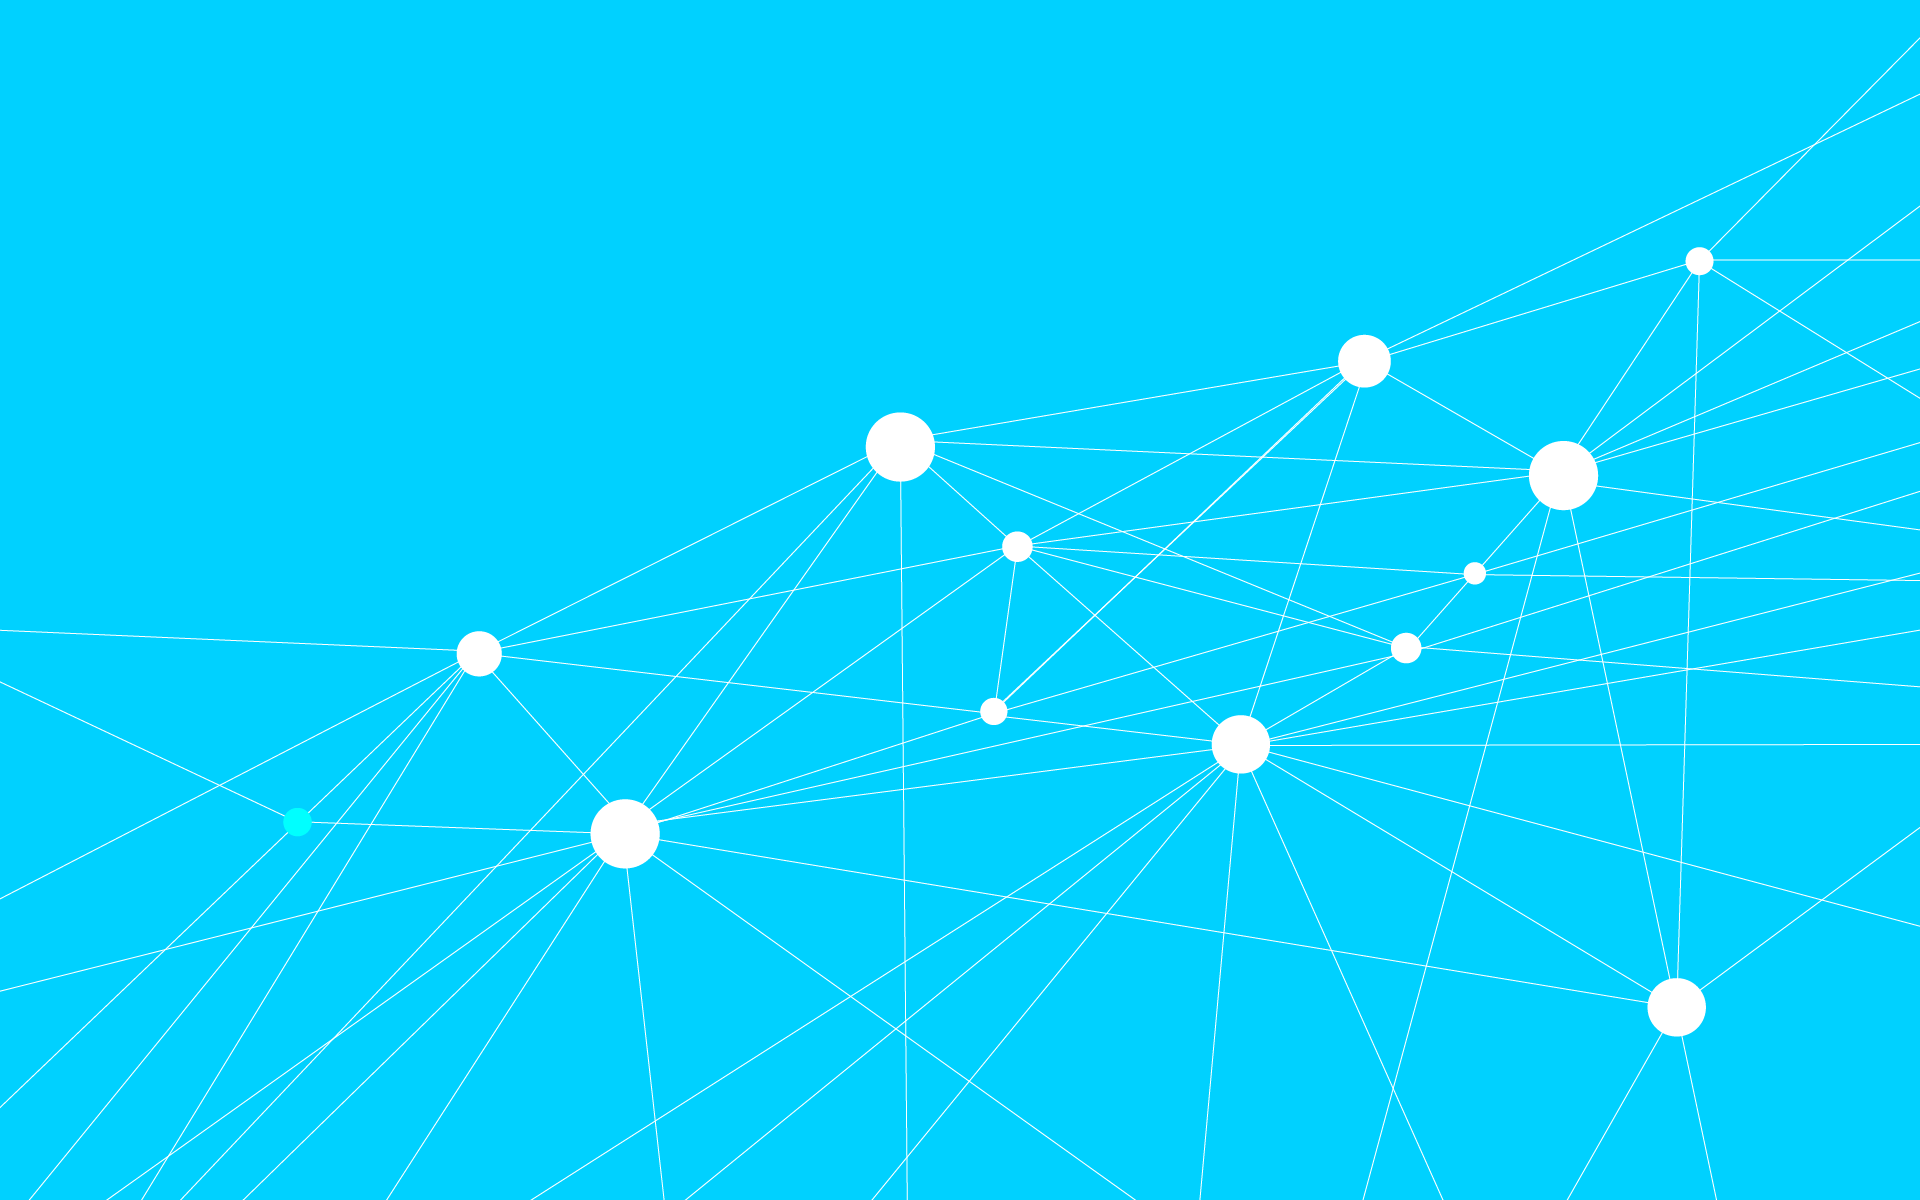
작성자:유성훈

##Downloading the dataset

###ML-100K

In [1]:
!wget "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
!unzip ml-100k.zip
!ls

--2022-06-12 21:51:06--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  2.83MB/s    in 1.7s    

2022-06-12 21:51:09 (2.83 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

###ML-1M

In [2]:
!wget "http://files.grouplens.org/datasets/movielens/ml-1m.zip"
!unzip ml-1m.zip
!ls

--2022-06-12 21:51:09--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  3.47MB/s    in 1.6s    

2022-06-12 21:51:11 (3.47 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
ml-100k  ml-100k.zip  ml-1m  ml-1m.zip	sample_data


##Importing the libraries

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

## Importing the dataset


In [4]:
# We won't be using this dataset.
movies = pd.read_csv('ml-1m/movies.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
users = pd.read_csv('ml-1m/users.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
ratings = pd.read_csv('ml-1m/ratings.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')

## Preparing the training set and the test set


In [5]:
training_set = pd.read_csv('ml-100k/u1.base', delimiter = '\t')
training_set = np.array(training_set, dtype = 'int')
test_set = pd.read_csv('ml-100k/u1.test', delimiter = '\t')
test_set = np.array(test_set, dtype = 'int')

## Getting the number of users and movies


In [6]:
nb_users = int(max(max(training_set[:, 0], ), max(test_set[:, 0])))
nb_movies = int(max(max(training_set[:, 1], ), max(test_set[:, 1])))

## Converting the data into an array with users in lines and movies in columns


In [7]:
def convert(data):
  new_data = []
  for id_users in range(1, nb_users + 1):
    id_movies = data[:, 1] [data[:, 0] == id_users]
    id_ratings = data[:, 2] [data[:, 0] == id_users]
    ratings = np.zeros(nb_movies)
    ratings[id_movies - 1] = id_ratings
    new_data.append(list(ratings))
  return new_data
training_set = convert(training_set)
test_set = convert(test_set)

## Converting the data into Torch tensors


In [8]:
training_set = torch.FloatTensor(training_set)
test_set = torch.FloatTensor(test_set)

## Converting the ratings into binary ratings 1 (Liked) or 0 (Not Liked)


In [9]:
training_set[training_set == 0] = -1
training_set[training_set == 1] = 0
training_set[training_set == 2] = 0
training_set[training_set >= 3] = 1
test_set[test_set == 0] = -1
test_set[test_set == 1] = 0
test_set[test_set == 2] = 0
test_set[test_set >= 3] = 1

## Creating the architecture of the Neural Network


In [10]:
class RBM():
  def __init__(self, nv, nh):
    self.W = torch.randn(nh, nv)
    self.a = torch.randn(1, nh)
    self.b = torch.randn(1, nv)
  def sample_h(self, x):
    wx = torch.mm(x, self.W.t())
    activation = wx + self.a.expand_as(wx)
    p_h_given_v = torch.sigmoid(activation)
    return p_h_given_v, torch.bernoulli(p_h_given_v)
  def sample_v(self, y):
    wy = torch.mm(y, self.W)
    activation = wy + self.b.expand_as(wy)
    p_v_given_h = torch.sigmoid(activation)
    return p_v_given_h, torch.bernoulli(p_v_given_h)
  def train(self, v0, vk, ph0, phk):
    self.W += (torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t()
    self.b += torch.sum((v0 - vk), 0)
    self.a += torch.sum((ph0 - phk), 0)
nv = len(training_set[0])
nh = 100
batch_size = 100
rbm = RBM(nv, nh)

## Training the RBM


In [11]:
nb_epoch = 10
for epoch in range(1, nb_epoch + 1):
  train_loss = 0
  s = 0.
  for id_user in range(0, nb_users - batch_size, batch_size):
    vk = training_set[id_user : id_user + batch_size]
    v0 = training_set[id_user : id_user + batch_size]
    ph0,_ = rbm.sample_h(v0)
    for k in range(10):
      _,hk = rbm.sample_h(vk)
      _,vk = rbm.sample_v(hk)
      vk[v0<0] = v0[v0<0]
    phk,_ = rbm.sample_h(vk)
    rbm.train(v0, vk, ph0, phk)
    train_loss += torch.mean(torch.abs(v0[v0 >= 0] - vk[v0 >= 0]))
    s += 1.
  print('epoch: '+str(epoch)+' loss: '+str(train_loss/s))


epoch: 1 loss: tensor(0.3549)
epoch: 2 loss: tensor(0.2511)
epoch: 3 loss: tensor(0.2397)
epoch: 4 loss: tensor(0.2487)
epoch: 5 loss: tensor(0.2493)
epoch: 6 loss: tensor(0.2481)
epoch: 7 loss: tensor(0.2473)
epoch: 8 loss: tensor(0.2470)
epoch: 9 loss: tensor(0.2469)
epoch: 10 loss: tensor(0.2489)


## Testing the RBM


In [12]:
test_loss = 0
s = 0.
for id_user in range(nb_users):
    v = training_set[id_user:id_user+1]
    vt = test_set[id_user:id_user+1]
    if len(vt[vt>=0]) > 0:
        _,h = rbm.sample_h(v)
        _,v = rbm.sample_v(h)
        test_loss += torch.mean(torch.abs(vt[vt>=0] - v[vt>=0]))
        s += 1.
print('test loss: '+str(test_loss/s))

test loss: tensor(0.2407)
